<a href="https://colab.research.google.com/github/bootnoodles/NBAMLRAPTOR/blob/master/NBAMLRAPTOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('/content/data.csv')

In [6]:
df2 = pd.read_csv('/content/posclean.csv')

In [7]:
df = pd.merge(df, df2, how='inner', on='player_name')

In [8]:
df.head()

,player_name,age,player_height,player_weight,net_rating,raptor_offense,raptor_defense,raptor_total,war_total,predator_total,pos
0,A.C. Green,35.0,205.74,102.058200,-1.880000,-0.294070,0.208818,-0.085252,3.759939,-0.339975,2
1,A.J. Bramlett,23.0,208.28,102.965384,-32.600000,-8.360250,-1.460235,-9.820485,-0.221281,-8.993465,2
2,A.J. Guyton,24.0,185.42,81.646560,-6.700000,-4.140556,-1.434026,-5.574582,-0.077551,-6.324631,1
3,Aaron Brooks,28.1,182.88,73.028312,-3.310000,0.160595,-2.531127,-2.370531,0.871362,-2.100771,1
4,Aaron Gray,26.0,213.36,122.469840,-4.728571,-2.667134,-0.114848,-2.781982,-0.042847,-2.948072,3


In [9]:
droplist = ['war_total', 'predator_total', 'raptor_defense', 
            'raptor_offense', 'net_rating', 'player_name']
df = df.drop(droplist, axis=1)

In [10]:
df.head()

,age,player_height,player_weight,raptor_total,pos
0,35.0,205.74,102.058200,-0.085252,2
1,23.0,208.28,102.965384,-9.820485,2
2,24.0,185.42,81.646560,-5.574582,1
3,28.1,182.88,73.028312,-2.370531,1
4,26.0,213.36,122.469840,-2.781982,3


In [11]:
df['raptor_total'].mean()

-2.5172282934710326

In [12]:
df4 = df
df5 = df

#The opposite of DRY

In [13]:
newlist2 = []
for items in df['age']:
  rounded = round(items)
  newlist2.append(rounded)

In [14]:
df.drop(['age'], axis=1)
df['age'] = newlist2

In [15]:
newlist3 = []
for items in df['player_height']:
  rounded = round(items)
  newlist3.append(rounded)

In [16]:
df.drop(['player_height'], axis=1)
df['player_height'] = newlist3

In [17]:
newlist4 = []
for items in df['player_weight']:
  rounded = round(items)
  newlist4.append(rounded)

In [18]:
df.drop(['player_weight'], axis=1)
df['player_weight'] = newlist4

# Couldve just used this function instead

```
def rounding(df, listnum):
  for items in df:
    rounded = round(items)
    listnum.append(rounded)
```
```
rounding(df['player_height'], newlist3)
```

# Using the average RAPTOR Score we will be able to tell if the player is above or below average by appending it to a feature.

In [19]:
df['raptor_total'].mean()

-2.5172282934710326

In [20]:
newlist = []
averagepred = -2.5172282934710326
for items in df['raptor_total']:
  if items > averagepred:
    newlist.append(1)
  elif items < averagepred:
    newlist.append(0)

In [21]:
df['aboveaverage'] = newlist

In [22]:
df.drop(['raptor_total'], axis=1)

,age,player_height,player_weight,pos,aboveaverage
0,35,206,102,2,1
1,23,208,103,2,0
2,24,185,82,1,0
3,28,183,73,1,1
4,26,213,122,3,0
...,...,...,...,...,...
1159,28,206,116,2,1
1160,29,213,112,3,0
1161,28,211,123,3,1
1162,32,213,118,3,0


# Baseline


In [23]:
df['aboveaverage'].value_counts(normalize=True)

1    0.530069
0    0.469931
Name: aboveaverage, dtype: float64

# Train/Validation Split

In [24]:
X = df.drop(['aboveaverage', 'raptor_total'], axis=1)
y = df['aboveaverage']

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Fitting


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
model = make_pipeline(
    RandomForestClassifier(n_jobs=1, random_state=42, max_depth=10)
  )

In [27]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=10, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=1,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [28]:
training_acc = model.score(X_train, y_train)
print('Training Accuracy Score:', training_acc)

validation_acc = model.score(X_val, y_val)
print('Validation Accuracy Score:', validation_acc)

Training Accuracy Score: 0.8646616541353384
Validation Accuracy Score: 0.6609442060085837


# Predicting "That Golden State Player" 




In [29]:
def testplayer(name, age, height, weight, pos):
  d = {'age': [age], 'player_height': [height], 'player_weight': [weight], 'pos': [pos]}
  name = pd.DataFrame(data=d)
  pred = model.predict(name)
  if pred == 1:
    print('This player is Above Average')
  else:
      print('This Player is Below Average')

In [30]:
testplayer('stephcurry', 26, 190, 84, 1)

This player is Above Average


# Permutation Importance

In [31]:
from sklearn.inspection import permutation_importance

In [32]:
perm_imp = permutation_importance(model, X_val, y_val, n_jobs=-1)

In [33]:
data = {'importances_mean' : perm_imp['importances_mean'],
        'importances_std' : perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_train.columns)
df.sort_values('importances_mean', ascending=False, inplace=True)

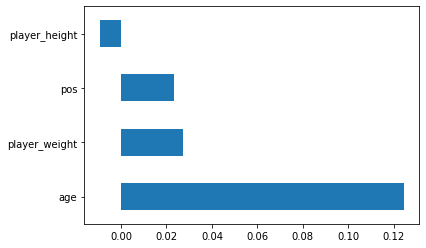

In [34]:
df.head(10).importances_mean.plot(kind='barh');

# Linear Regression


In [35]:
X1 = df4.drop(['aboveaverage', 'raptor_total'], axis=1)
y1 = df4['raptor_total']

In [36]:
y_pred = [y1.mean()] * len(y)

In [39]:
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
mean_absolute_error(y, y_pred)

3.047297021993369

In [41]:
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [45]:
model2 = LinearRegression()
model2.fit(X1_train, y1_train)
y_pred = model.predict(X1)

In [46]:
model2.predict(X_val)


array([-1.17731051, -1.61959997, -2.59090022, -2.42282817, -4.27227636,
       -2.17862528, -2.6565168 , -1.95429208, -3.11487802, -0.88541165,
       -3.82632446, -3.24031452, -3.00646819, -1.80838337, -4.72041649,
       -1.92683436, -0.80472268, -0.44631155, -1.73119915, -2.42282817,
       -1.66484458, -1.58196738, -2.83054496, -3.90203445, -3.45389432,
        0.23946679, -2.44557005, -3.70070626, -1.19918069, -1.51413859,
       -2.67137747, -4.13761814, -2.08568469, -2.04323083, -1.0635231 ,
       -3.79378232, -3.80137036, -4.77570051, -3.81449367, -2.11806913,
       -2.88306222, -2.66964011, -1.17731051, -2.74798316, -0.17104076,
       -1.9920301 , -1.95674344, -3.177307  , -3.83902694, -3.17266742,
       -2.98151409, -3.33225574, -4.82956432, -0.29618409, -2.33676162,
       -5.06962989, -3.81449367, -2.36446024, -2.72742951, -2.15865016,
       -3.78621652, -2.32917358, -1.03377172, -3.01714014, -3.46219636,
       -3.23069595, -2.71456933, -3.43286581, -1.85199606, -4.92

In [54]:
y1.min()

-37.92562198